For this project we will be using Pokemon dataset. This dataset contains ~40 images per 1,000 Pokémon species, structured in subdirectories for each class. Each image is resized to 128x128 pixels and stored as a PNG file.

This dataset is availible here:

https://www.kaggle.com/datasets/noodulz/pokemon-dataset-1000/data

Main objective of  our project

In [23]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 128
BATCH_SIZE = 64
LATENT_DIM = 100
EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Let's begin with the first task - creatig a Convolutional NN for pokemon image classification

In [3]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                  #делим на 255 получаем диапазон -> [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3)  # -> [-1, 1]; функция активации в генераторе будет tanh, которая работает с таким диапазоном
])

In [11]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
drive_data_dir = "/content/drive/MyDrive/Pokemon-GAN/data/dataset"

In [14]:
dataset = datasets.ImageFolder(root=drive_data_dir, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 26549
    Root location: /content/drive/MyDrive/Pokemon-GAN/data/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [20]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader

In [21]:
# Берём один батч
images, labels = next(iter(dataloader))
print("Форма батча:", images.shape)   # (16, 3, 128, 128)
print("Лейблы:", labels)

Форма батча: torch.Size([64, 3, 128, 128])
Лейблы: tensor([598, 685, 912,  76, 407, 849, 904, 424, 314, 379, 742, 738, 300, 558,
        372, 272,   0, 250, 409, 801, 548, 748, 890, 777,   6, 231, 542,  74,
        813, 600, 298, 744, 119, 138,  44, 476, 683, 205, 583, 165, 701, 285,
        518, 231, 548, 729,  90, 492, 358, 111, 633, 413, 784, 508, 588, 352,
        841, 738, 480, 280, 865, 319, 746,  43])


In [26]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_with_idx_names(imgs, labels):
    imgs = imgs * 0.5 + 0.5  # денормализация [-1,1] → [0,1]
    batch_size = imgs.size(0)

    fig, axes = plt.subplots(1, batch_size, figsize=(3*batch_size, 3))
    if batch_size == 1:
        axes = [axes]  # чтобы был iterable, если 1 картинка

    for i in range(batch_size):
        img = imgs[i].permute(1, 2, 0).numpy()  # (C,H,W) → (H,W,C)
        axes[i].imshow(img)
        axes[i].set_title(f"{labels[i].item()} → {idx_to_class[labels[i].item()]}", fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

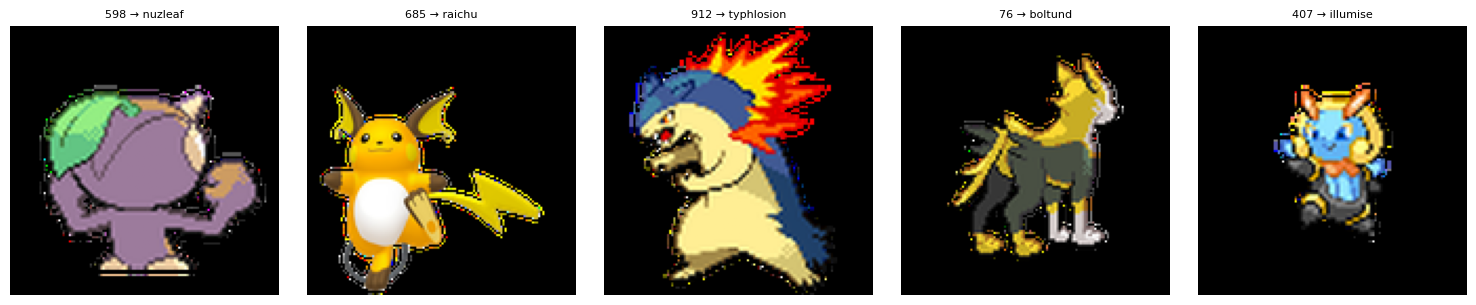

In [28]:
show_images_with_idx_names(images[:5], labels[:5])

We will instantiate image generators to process our pokemons. The are three generators for training, testing and validation respectively.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # input: z (batch, latent_dim, 1, 1)
            # для каждого изображения из батча формируется 128 карт признаков размером 8х8
            nn.ConvTranspose2d(in_channels=latent_dim,
                               out_channels=128,
                               kernel_size=8,
                               stride=1,
                               padding=0,
                               bias=False), # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False), # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False), # (16, 64, 64)
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),  # (3, 128, 128)
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),  # (64, 64, 64)
            # не делается batchnorm потому что напермо слое важно сохранить распределение настоящих изображений
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(64, 128, 4, 2, 1, bias=False), # (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False), # (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False), # (512, 8, 8)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 8, 1, 0, bias=False),  # (1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.net(img).view(-1, 1)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
generator = Generator(LATENT_DIM).to(DEVICE)
discriminator = Discriminator().to(DEVICE)

In [ ]:
generator.apply(weights_init)
discriminator.apply(weights_init)

In [ ]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(16, LATENT_DIM, 1, 1, device=DEVICE)

In [ ]:
n_gen_steps = 2
n_disc_steps = 1

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(DEVICE)
        batch_size = real_imgs.size(0)

        # ------------------
        # Обучаем дискриминатор
        # ------------------
        for _ in range(n_disc_steps):
            optimizer_D.zero_grad()
            valid = torch.ones(batch_size, 1, device=DEVICE)
            fake = torch.zeros(batch_size, 1, device=DEVICE)

            real_loss = criterion(discriminator(real_imgs), valid)
            z = torch.randn(batch_size, LATENT_DIM, 1, 1, device=DEVICE)
            gen_imgs = generator(z)
            fake_loss = criterion(discriminator(gen_imgs.detach()), fake)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        # ------------------
        # Обучаем генератор несколько раз
        # ------------------
        for _ in range(n_gen_steps):
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, LATENT_DIM, 1, 1, device=DEVICE)
            gen_imgs = generator(z)
            g_loss = criterion(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

In [ ]:
with torch.no_grad():
        gen_imgs = generator(fixed_noise).cpu()
        gen_imgs = (gen_imgs + 1) / 2  # денормализация
        plt.figure(figsize=(8, 8))
        for k in range(16):
            plt.subplot(4, 4, k+1)
            plt.imshow(gen_imgs[k].permute(1, 2, 0).numpy())
            plt.axis("off")
        plt.savefig(f"generated_epoch_{epoch+1}.png")
        plt.close()